<a href="https://colab.research.google.com/github/NiklasElsaesser/FaceBias/blob/main/bias_testing_e10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing the Model
Here we upload a new picture and test if the model recognizes the face according to the trained labels and **if** the model has any bias towards men that smile.

allow for the input of a new picture on which the algorithm wasnt trained to test for the bias of the algorithm.

In [1]:
!pip install matplotlib
!pip install opencv-contrib-python

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Hier die Parameter für die Auswertung ändern!**
1. Unter *Laufzeit* "Alle ausführen" anklicken.
2. Im G-Drive anmelden, wichtig -> der Drive mit den Bilder muss in eurem Drive verlinkt||verlinkt sein.
3. Auf der linken Seiten unter Dateien den Pfad für *face_emotion_model_path* sowie für *uploaded_img_path* ersetzen.
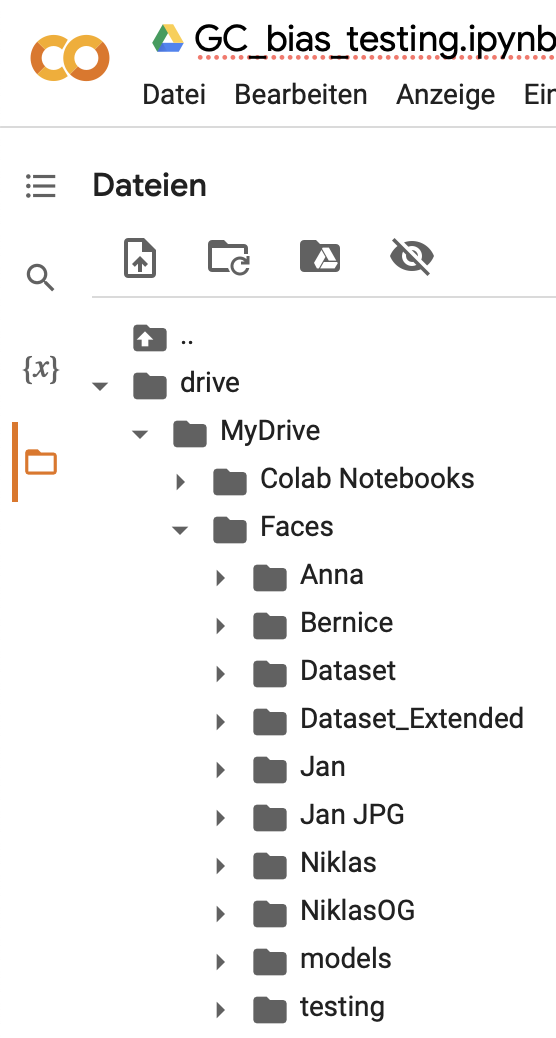

4. Für jedes Model unter *models* die Bilder in *testing* durchgehen. Bsp. mit dem Model: *emotion_model_extended_epochs1000.h5* alle Bilder durchgehen (niklas_happy.jpg, niklas_neutral.jpg,...).
5. Die Ergebnisse so dokumentieren das im Nachgang u.a. eine grafische Auswertung durchgeführt werden kann. (*emotion_model_extended_epochs1000.h5* hat *niklas_happy.jpg* als "Frau, Happy" erkannt, *niklas_neutral.jpg* wurde als "Mann, neutral" erkant, das erste war somit in unserem Fall "richtig", das zweite auch. Wäre Niklas im ersten Fall auch als "Mann, neutral" erkannt worden, wäre dies falsch gewesen.)
6. Die Ergebnisse der Auswertung in der Readme.md im GitHub Projekt einfügen, alternativ in einem Word||Google Doc niederschreiben.

Danke euch.


## 1. Testing
1. Importing the trained model
2. Uploading the test images
3. Preprocessing the test images
4. Predicting the gender and emotions

In [10]:
import glob
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# List to store prediction results and image paths
predictions = []

# Load your face recognition model
face_emotion_model_path = '/content/drive/MyDrive/Faces/models/emotion_model_fv_e10.h5'
face_recognition_model = load_model(face_emotion_model_path)

# Function to preprocess images
def preprocess_image(img):
    img = cv2.resize(img, (48, 48))
    img = img.astype('float') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# File path to the uploaded image
#uploaded_img_path = '/content/drive/MyDrive/Faces/testing/niklas_vhappy.jpg'
uploaded_img_folder_path = '/content/drive/MyDrive/Faces/testing'

# Read the uploaded image
allFiles = glob.glob(glob.escape(uploaded_img_folder_path) + "/*.jpg")

for imgPath in allFiles:
    img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Unable to read the image.")
    else:
        # Preprocess the image
        processed_img = preprocess_image(img)
        # Predict gender using the model
        predicted_gender = face_recognition_model.predict(processed_img)

        # Map the predicted index to gender and emotion labels
        genders = ["men", "women"]
        emotions = ["happy", "neutral"]

        gender_index = np.argmax(predicted_gender)
        gender_label = genders[gender_index // len(emotions)]
        emotion_label = emotions[gender_index % len(emotions)]

        # Extract only the filename from the full image path
        img_filename = os.path.basename(imgPath)

        # Print the predicted gender and emotion with the image filename
        #print(f"Image Path: " + img_filename)
        #print(f"Predicted Gender: {gender_label.capitalize()}")
        #print(f"Predicted Emotion: {emotion_label.capitalize()}")

        #faceImg = cv2.imread(imgPath)
        #plt.imshow(faceImg)

        # Append prediction results (filename only) and gender/emotion labels to the list
        predictions.append([img_filename, gender_label.capitalize(), emotion_label.capitalize()])


1/1 [==============================] - 0s 23ms/step


## 2. Predictions
Saving the predictions in a Dataframe and as CSV

In [11]:
import pandas as pd

# Create a DataFrame from the predictions list
df = pd.DataFrame(predictions, columns=["Image Path", "Predicted Gender", "Predicted Emotion"])

# Save the DataFrame as a CSV file
output_csv_path = '/content/drive/MyDrive/Faces/predictions/predictions_e10.csv'
df.to_csv(output_csv_path, index=False)

print(f"Prediction results saved at: {output_csv_path}")
print("the table/n", df)


Prediction results saved at: /content/drive/MyDrive/Faces/predictions/predictions_e10.csv
the table/n                     Image Path Predicted Gender Predicted Emotion
0              jan_neutral.jpg              Men           Neutral
1             niklas_happy.jpg              Men           Neutral
2                jan_happy.jpg              Men           Neutral
3               anna_happy.jpg              Men           Neutral
4             anna_neutral.jpg              Men           Neutral
5            bernice_happy.jpg            Women             Happy
6          bernice_neutral.jpg            Women             Happy
7             anna_happy_2.jpg            Women             Happy
8         niklas_neutral_0.jpg            Women             Happy
9         niklas_neutral_1.jpg              Men           Neutral
10          niklas_happy_1.jpg              Men           Neutral
11          anna_neutral_1.jpg            Women             Happy
12          anna_neutral_2.jpg          

## 3. Connecting Bias
Analyzing the results of the predictions by checking the parameters of the tested pictures.

In [12]:
# Check if 'niklas_happy' is labeled as 'men' and 'neutral'
niklas_neutral_condition = (df['Image Path'].str.contains('niklas_neutral')) & (df['Predicted Gender'] == 'Men') & (df['Predicted Emotion'] == 'Neutral')
jan_neutral_condition = (df['Image Path'].str.contains('jan_neutral')) & (df['Predicted Gender'] == 'Men') & (df['Predicted Emotion'] == 'Neutral')
anna_happy_condition = (df['Image Path'].str.contains('anna_happy')) & (df['Predicted Gender'] == 'Women') & (df['Predicted Emotion'] == 'Happy')
bernice_happy_condition = (df['Image Path'].str.contains('bernice_happy')) & (df['Predicted Gender'] == 'Women') & (df['Predicted Emotion'] == 'Happy')

# Create a new column 'Correct Prediction' and set values based on the conditions
df['Correct Prediction'] = 'Incorrect'
df.loc[niklas_neutral_condition, 'Correct Prediction'] = 'Correct'
df.loc[jan_neutral_condition, 'Correct Prediction'] = 'Correct'
df.loc[anna_happy_condition, 'Correct Prediction'] = 'Correct'
df.loc[bernice_happy_condition, 'Correct Prediction'] = 'Correct'

print(df)


                    Image Path Predicted Gender Predicted Emotion  \
0              jan_neutral.jpg              Men           Neutral   
1             niklas_happy.jpg              Men           Neutral   
2                jan_happy.jpg              Men           Neutral   
3               anna_happy.jpg              Men           Neutral   
4             anna_neutral.jpg              Men           Neutral   
5            bernice_happy.jpg            Women             Happy   
6          bernice_neutral.jpg            Women             Happy   
7             anna_happy_2.jpg            Women             Happy   
8         niklas_neutral_0.jpg            Women             Happy   
9         niklas_neutral_1.jpg              Men           Neutral   
10          niklas_happy_1.jpg              Men           Neutral   
11          anna_neutral_1.jpg            Women             Happy   
12          anna_neutral_2.jpg            Women             Happy   
13           anna_neutral3.jpg    

In [15]:
# Extract the first word from 'Image Path' and create a new column with that name
df['Name'] = df['Image Path'].str.split('_').str[0]

# Save the DataFrame as a CSV file
output_csv_path = '/content/drive/MyDrive/Faces/predictions/predictions_checked_e10.csv'
df.to_csv(output_csv_path, index=False)

print(f"Prediction results saved at: {output_csv_path}")
print(df)

Prediction results saved at: /content/drive/MyDrive/Faces/predictions/predictions_checked_e10.csv
                    Image Path Predicted Gender Predicted Emotion  \
0              jan_neutral.jpg              Men           Neutral   
1             niklas_happy.jpg              Men           Neutral   
2                jan_happy.jpg              Men           Neutral   
3               anna_happy.jpg              Men           Neutral   
4             anna_neutral.jpg              Men           Neutral   
5            bernice_happy.jpg            Women             Happy   
6          bernice_neutral.jpg            Women             Happy   
7             anna_happy_2.jpg            Women             Happy   
8         niklas_neutral_0.jpg            Women             Happy   
9         niklas_neutral_1.jpg              Men           Neutral   
10          niklas_happy_1.jpg              Men           Neutral   
11          anna_neutral_1.jpg            Women             Happy   
12   

## 4. Analyzing
Reviewing the predicted results, analyzing the inherited bias and its cause.

<Figure size 1000x600 with 0 Axes>

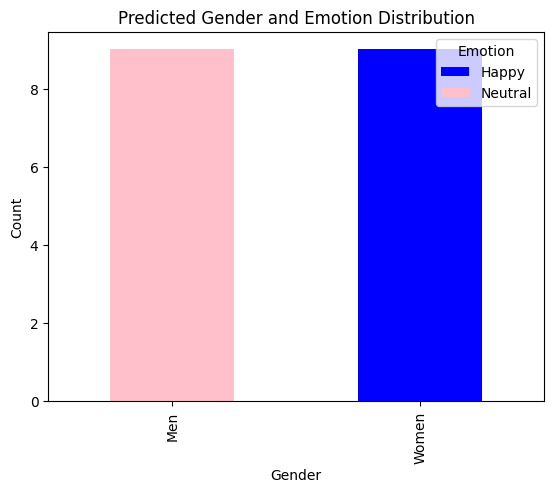

In [16]:
import matplotlib.pyplot as plt

# Counting the occurrences of each combination of Predicted Gender and Predicted Emotion
gender_emotion_counts = df.groupby(['Predicted Gender', 'Predicted Emotion']).size().unstack()

# Creating a stacked bar chart
plt.figure(figsize=(10, 6))
gender_emotion_counts.plot(kind='bar', stacked=True, color=['blue', 'pink', 'green', 'gray'])
plt.title('Predicted Gender and Emotion Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Emotion', loc='upper right')
plt.show()


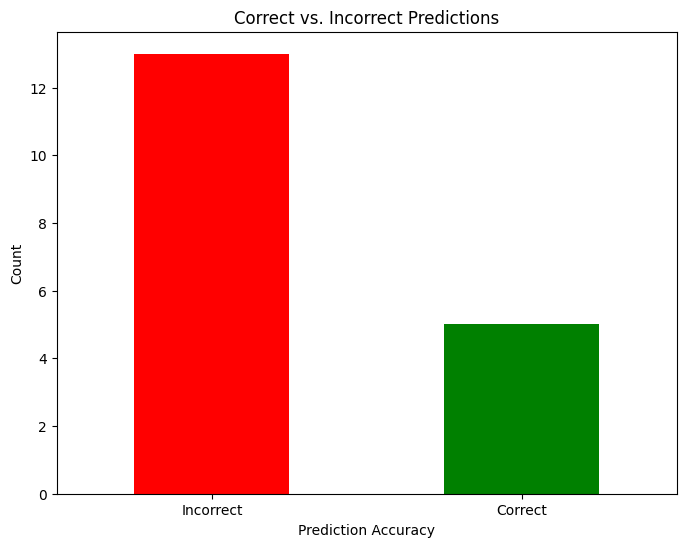

In [17]:
# Bar chart for Correct vs. Incorrect Predictions
plt.figure(figsize=(8, 6))
df['Correct Prediction'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Correct vs. Incorrect Predictions')
plt.xlabel('Prediction Accuracy')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

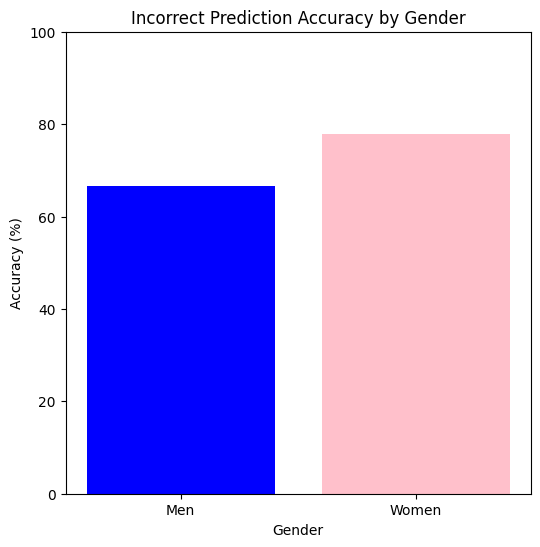

In [19]:
# Calculate accuracy for incorrect predictions for Men and Women
men_incorrect_accuracy = df.loc[(df['Predicted Gender'] == 'Men') & (df['Correct Prediction'] == 'Incorrect')].shape[0] / df.loc[df['Predicted Gender'] == 'Men'].shape[0] * 100
women_incorrect_accuracy = df.loc[(df['Predicted Gender'] == 'Women') & (df['Correct Prediction'] == 'Incorrect')].shape[0] / df.loc[df['Predicted Gender'] == 'Women'].shape[0] * 100

# Bar chart for Incorrect Prediction Accuracy by Gender
plt.figure(figsize=(6, 6))
plt.bar(['Men', 'Women'], [men_incorrect_accuracy, women_incorrect_accuracy], color=['blue', 'pink'])
plt.title('Incorrect Prediction Accuracy by Gender')
plt.xlabel('Gender')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


In [20]:
# Calculate misprediction rates for different gender, emotion, and image path combinations
gender_emotion_imagepath_misprediction_rates = []
for gender in df['Predicted Gender'].unique():
    for emotion in df['Predicted Emotion'].unique():
        for image_path in df['Image Path'].unique():
            subset = df.loc[(df['Predicted Gender'] == gender) & (df['Predicted Emotion'] == emotion) & (df['Image Path'] == image_path)]
            if subset.shape[0] > 0:  # Check if subset has any rows before calculating misprediction rate
                misprediction_rate = subset.loc[(subset['Predicted Gender'] == gender) & (subset['Correct Prediction'] == 'Incorrect')].shape[0] / subset.shape[0] * 100
                gender_emotion_imagepath_misprediction_rates.append({'Gender': gender, 'Emotion': emotion, 'Image Path': image_path, 'Misprediction Rate': misprediction_rate})

# Find the combination with the highest misprediction rate
if gender_emotion_imagepath_misprediction_rates:
    max_misprediction_rate_combination = max(gender_emotion_imagepath_misprediction_rates, key=lambda x: x['Misprediction Rate'])

    # Print misprediction rates for different combinations
    for combination in gender_emotion_imagepath_misprediction_rates:
        print("Misprediction Rate for {} with {} emotion and {} image path: {:.2f}%".format(combination['Gender'], combination['Emotion'], combination['Image Path'], combination['Misprediction Rate']))

    # Print combination with the highest misprediction rate
    print("The combination with the highest misprediction rate:")
    print("Gender: {}, Emotion: {}, Image Path: {}, Misprediction Rate: {:.2f}%".format(max_misprediction_rate_combination['Gender'], max_misprediction_rate_combination['Emotion'], max_misprediction_rate_combination['Image Path'], max_misprediction_rate_combination['Misprediction Rate']))
else:
    print("No data available for the specified combinations of gender, emotion, and image path.")


Misprediction Rate for Men with Neutral emotion and jan_neutral.jpg image path: 0.00%
Misprediction Rate for Men with Neutral emotion and niklas_happy.jpg image path: 100.00%
Misprediction Rate for Men with Neutral emotion and jan_happy.jpg image path: 100.00%
Misprediction Rate for Men with Neutral emotion and anna_happy.jpg image path: 100.00%
Misprediction Rate for Men with Neutral emotion and anna_neutral.jpg image path: 100.00%
Misprediction Rate for Men with Neutral emotion and niklas_neutral_1.jpg image path: 0.00%
Misprediction Rate for Men with Neutral emotion and niklas_happy_1.jpg image path: 100.00%
Misprediction Rate for Men with Neutral emotion and niklas_happy_woBeard.jpg image path: 100.00%
Misprediction Rate for Men with Neutral emotion and niklas_neutral_woBeard.jpg image path: 0.00%
Misprediction Rate for Women with Happy emotion and bernice_happy.jpg image path: 0.00%
Misprediction Rate for Women with Happy emotion and bernice_neutral.jpg image path: 100.00%
Mispred

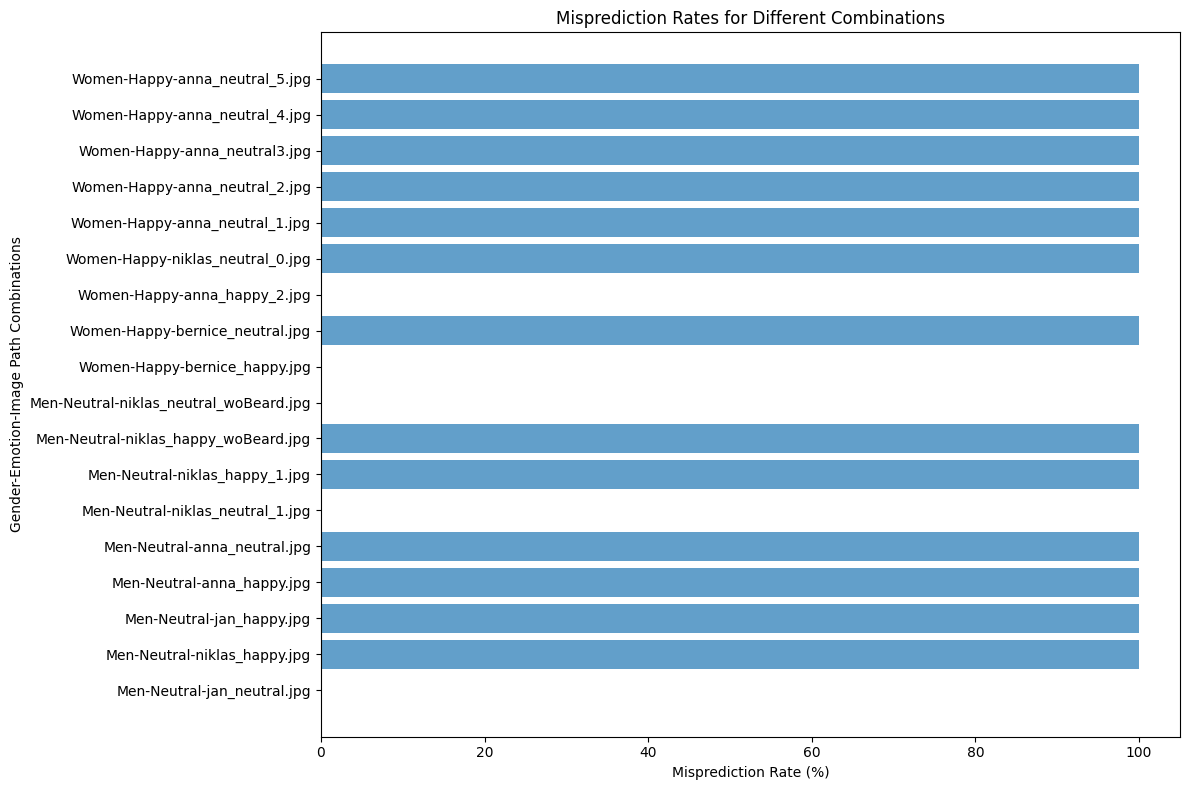

In [21]:
import matplotlib.pyplot as plt

# Data for visualization
genders = [combination['Gender'] for combination in gender_emotion_imagepath_misprediction_rates]
emotions = [combination['Emotion'] for combination in gender_emotion_imagepath_misprediction_rates]
image_paths = [combination['Image Path'] for combination in gender_emotion_imagepath_misprediction_rates]
misprediction_rates = [combination['Misprediction Rate'] for combination in gender_emotion_imagepath_misprediction_rates]

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(genders)), misprediction_rates, align='center', alpha=0.7)
ax.set_yticks(range(len(genders)))
ax.set_yticklabels(['{}-{}-{}'.format(g, e, p) for g, e, p in zip(genders, emotions, image_paths)])
ax.set_xlabel('Misprediction Rate (%)')
ax.set_ylabel('Gender-Emotion-Image Path Combinations')
ax.set_title('Misprediction Rates for Different Combinations')

# Show the plot
plt.tight_layout()
plt.show()


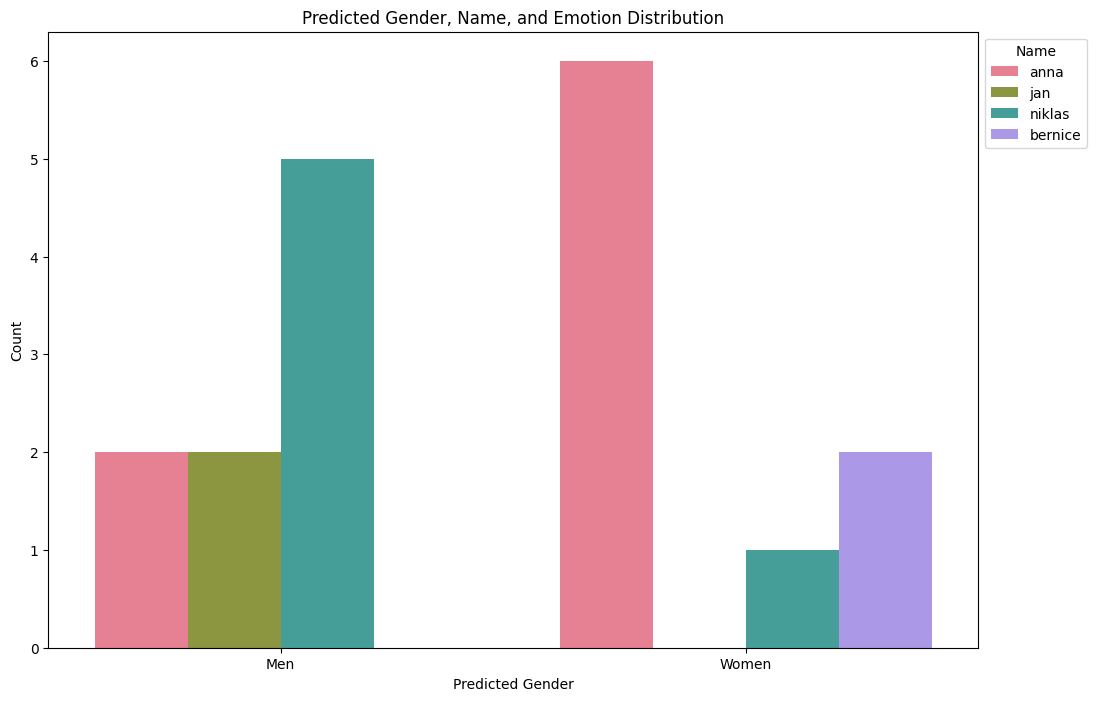

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the DataFrame by 'Predicted Gender', 'Name', and 'Predicted Emotion', and count the occurrences
grouped_df = df.groupby(['Predicted Gender', 'Name', 'Predicted Emotion']).size().reset_index(name='Count')

# Plotting the grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Predicted Gender', y='Count', hue='Name', data=grouped_df, dodge=True, palette='husl')
plt.title('Predicted Gender, Name, and Emotion Distribution')
plt.xlabel('Predicted Gender')
plt.ylabel('Count')
plt.legend(title='Name', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
